In [622]:
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats

# Dataset  M5 Forecasting Accuracy

link: https://www.kaggle.com/competitions/m5-forecasting-accuracy 

<li><b> sales data </b> - contains the historical daily unit sales data per product and store. Products fall into one of three categories - Hobbies, Foods and Household. The sales data is provided for 10 stores across 3 states - 4 in California (CA), 3 in WI (Wisconsin) and 3 in TX (Texas) . Each time series provides data for 1969 unique dates.
<li><b> calendar </b>  - contains information about the dates on which the products are sold.

For this task, I chose FOOD weekly sales data for CA_1 California store.

# Import and preprocess data

In [2]:
sales_df_train = pd.read_csv("/Users/alyaatmaeva/Desktop/itmo/SMLT /SMLT-01 - Time Series Analysis/sales_train_evaluation.csv")

In [3]:
sales_df_test = pd.read_csv("/Users/alyaatmaeva/Desktop/itmo/SMLT /SMLT-01 - Time Series Analysis/sales_test_evaluation.csv")

In [4]:
calendar =  pd.read_csv("/Users/alyaatmaeva/Desktop/itmo/SMLT /SMLT-01 - Time Series Analysis/calendar.csv")

In [5]:
calendar.reset_index(inplace = True)
calendar['index'] =  calendar['index'].apply(lambda x: "d_"+str(x+1))

In [6]:
sales_df_train.reset_index(inplace = True)

In [7]:
sales_df_test = sales_df_test.drop(['item_id','dept_id','cat_id','store_id','state_id'], axis = 1).reset_index()

In [8]:
sales_df = sales_df_train.merge(sales_df_test,  left_on='index', right_on='index')

In [9]:
sales_df.drop(['index'] , axis = 1, inplace = True)

In [10]:
calendar

,index,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,d_1965,2016-06-15,11620,Wednesday,5,6,2016,NaN,NaN,NaN,NaN,0,1,1
1965,d_1966,2016-06-16,11620,Thursday,6,6,2016,NaN,NaN,NaN,NaN,0,0,0
1966,d_1967,2016-06-17,11620,Friday,7,6,2016,NaN,NaN,NaN,NaN,0,0,0
1967,d_1968,2016-06-18,11621,Saturday,1,6,2016,NaN,NaN,NaN,NaN,0,0,0


In [11]:
sales_df

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,2,0,0,1,0,1,3,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,0,1,0,0,2,1,1,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,3,2,1,0,2,1,0,1,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,3,3,4,2,1,6,3,1,4,3
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,2,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,...,1,4,0,0,1,1,1,1,1,0
30486,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,...,4,1,0,1,0,1,0,0,0,0
30487,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,...,1,1,2,1,2,1,1,1,1,0
30488,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,...,0,0,2,0,1,3,0,2,1,5


In [12]:
sales_df.store_id.unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [83]:
foods_ca = sales_df[(sales_df['state_id']=='CA')
                    &(sales_df['cat_id']=='FOODS')
                    &(sales_df['store_id']=='CA_1')].loc[:,'d_1':].sum(axis=0).reset_index()

In [84]:
foods_ca.rename( columns = { 0 : 'sales'}, inplace = True)

In [85]:
foods_ca = foods_ca.merge(calendar[['index','date']], how = 'left', on = 'index').drop(['index'], axis = 1)

In [86]:
foods_ca = foods_ca[['date','sales']]

In [87]:
foods_ca['date'] = pd.to_datetime(foods_ca.date, format='%Y-%m-%d')

In [88]:
foods_ca.index = foods_ca['date']
foods_ca = foods_ca.resample('W-MON').sum().reset_index()

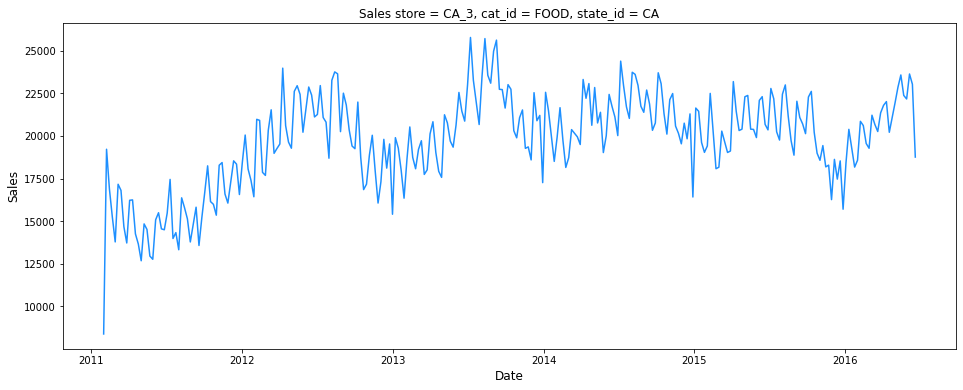

In [89]:
plt.figure(figsize=(16,6))

plt.plot(foods_ca["date"],foods_ca["sales"],color = 'dodgerblue')
plt.xlabel("Date", size =12)
plt.ylabel("Sales", size =12)
plt.title("Sales store = CA_3, cat_id = FOOD, state_id = CA", size =12) 
plt.show()

In [90]:
foods_ca = foods_ca[-234:].reset_index(drop = True)

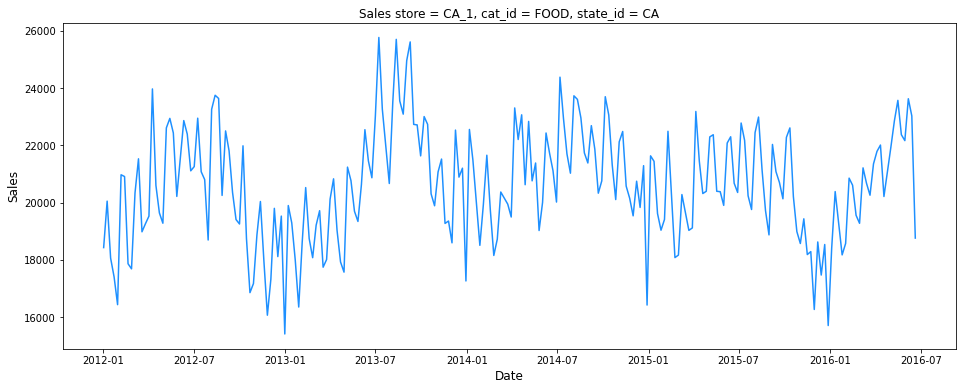

In [91]:

plt.figure(figsize=(16,6))

plt.plot(foods_ca["date"],foods_ca["sales"],color = 'dodgerblue')
plt.xlabel("Date", size =12)
plt.ylabel("Sales", size =12)
plt.title("Sales store = CA_1, cat_id = FOOD, state_id = CA", size =12) 
plt.show()

In [92]:
foods_ca

,date,sales
0,2012-01-02,18425
1,2012-01-09,20049
2,2012-01-16,18056
3,2012-01-23,17397
4,2012-01-30,16430
...,...,...
229,2016-05-23,22372
230,2016-05-30,22165
231,2016-06-06,23629
232,2016-06-13,23028


# ARIMA

## STL decomposition

In [23]:
result = seasonal_decompose(foods_ca.set_index('date').dropna(), model='additive')

<Figure size 1440x576 with 0 Axes>

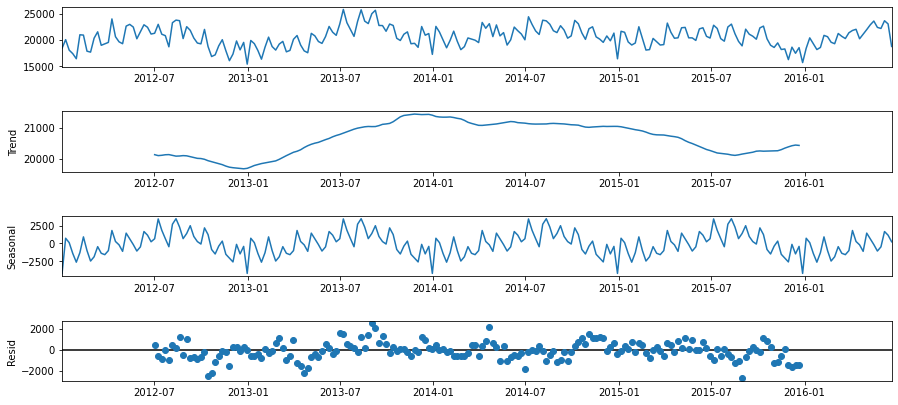

In [24]:
plt.figure(figsize=(20,8))
fig=result.plot()
fig.set_figheight(6)
fig.set_figwidth(14)

plt.show()

In [25]:
dft = sm.tsa.stattools.adfuller(foods_ca.sales.dropna())
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(foods_ca.sales.dropna())[1])

Dickey-Fuller test: p=0.000694


In [26]:
if dft[0] < dft[4]["5%"]:
    print ("Reject H0 - Time Series is Stationary")
else:
    print ("Not Reject H0 - Time series is Non-Stationar")

Reject H0 - Time Series is Stationary


In [27]:
dft

(-4.186647604837634,
 0.0006940435367944448,
 15,
 218,
 {'1%': -3.460707667106296,
  '5%': -2.874891213486339,
  '10%': -2.573885987711472},
 3698.646339849424)

In [93]:
foods_ca['sales_box'], lmbda = stats.boxcox(foods_ca['sales'])

In [94]:
foods_ca['diff_sales'] = foods_ca.sales - foods_ca.sales.shift(1)
#foods_ca['diff_sales'] = foods_ca.diff_sales - foods_ca.diff_sales.shift(1)

In [95]:
foods_ca_n = foods_ca.dropna()

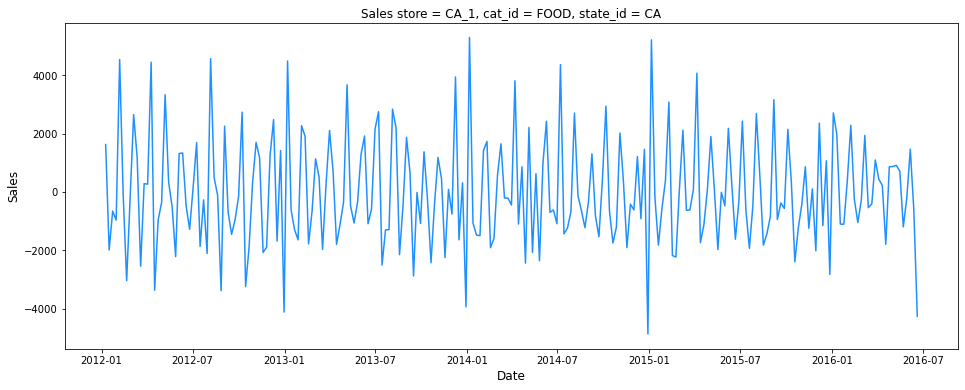

In [31]:

test_lenght = 47
plt.figure(figsize=(16,6))

plt.plot(foods_ca_n['date'],foods_ca_n['diff_sales'],color = 'dodgerblue')
plt.xlabel("Date", size =12)
plt.ylabel("Sales", size =12)
plt.title("Sales store = CA_1, cat_id = FOOD, state_id = CA", size =12) 
plt.show()

In [32]:
dft2 = sm.tsa.stattools.adfuller(foods_ca['sales_box'])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(foods_ca_n.diff_sales)[1])

Dickey-Fuller test: p=0.001290


In [33]:
dft2

(-4.196007599524482,
 0.0006692288012659622,
 15,
 218,
 {'1%': -3.460707667106296,
  '5%': -2.874891213486339,
  '10%': -2.573885987711472},
 4457.4577550028225)

## Autocorrelation and partial autocorrelation components

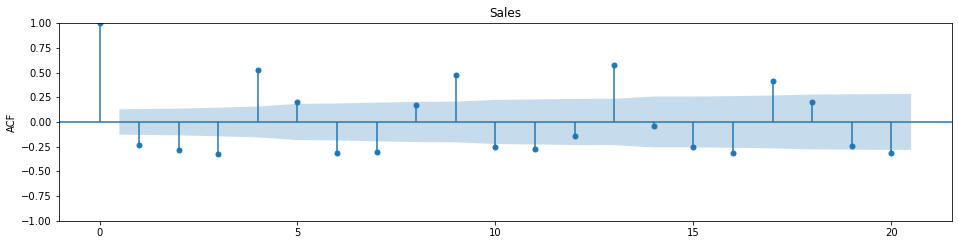

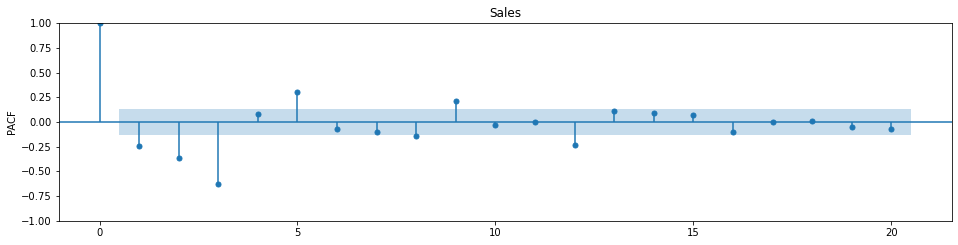

In [114]:
plt.figure(figsize=(16,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(foods_ca_n.diff_sales.values, lags=20, ax=ax)
plt.ylabel('ACF')
plt.title('Sales')


plt.figure(figsize=(16,8))

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(foods_ca_n.diff_sales.values, lags=20, ax=ax, title=None)
plt.ylabel('PACF')
plt.title('Sales')
plt.show()

## ARIMA Model 

In [54]:
from itertools import product

ps = range(0, 3)
d=1
qs = range(0, 7)
Ps = range(3, 5)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
print (u"Models to analyse by AIC:", len(parameters_list))

[(0, 0, 3, 0), (0, 0, 4, 0), (0, 1, 3, 0), (0, 1, 4, 0), (0, 2, 3, 0), (0, 2, 4, 0), (0, 3, 3, 0), (0, 3, 4, 0), (0, 4, 3, 0), (0, 4, 4, 0), (0, 5, 3, 0), (0, 5, 4, 0), (0, 6, 3, 0), (0, 6, 4, 0), (1, 0, 3, 0), (1, 0, 4, 0), (1, 1, 3, 0), (1, 1, 4, 0), (1, 2, 3, 0), (1, 2, 4, 0), (1, 3, 3, 0), (1, 3, 4, 0), (1, 4, 3, 0), (1, 4, 4, 0), (1, 5, 3, 0), (1, 5, 4, 0), (1, 6, 3, 0), (1, 6, 4, 0), (2, 0, 3, 0), (2, 0, 4, 0), (2, 1, 3, 0), (2, 1, 4, 0), (2, 2, 3, 0), (2, 2, 4, 0), (2, 3, 3, 0), (2, 3, 4, 0), (2, 4, 3, 0), (2, 4, 4, 0), (2, 5, 3, 0), (2, 5, 4, 0), (2, 6, 3, 0), (2, 6, 4, 0)]
Models to analyse by AIC: 42


In [97]:
y_train= foods_ca.sales_box
y_test=foods_ca_n.diff_sales[-test_lenght:]
results = []
best_aic = float("inf")


# ignore warnings 
warnings.filterwarnings('ignore')
i=0 
for param in parameters_list:
    print(i)
    i=i+1
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(y_train, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())     

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
     parameters          aic
3  (2, 1, 4, 0)  4689.519502
2  (2, 1, 3, 0)  4693.232807
1  (0, 0, 4, 0)  4702.509967
0  (0, 0, 3, 0)  4709.447351


In [98]:

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

In [99]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           sales_box   No. Observations:                  234
Model:             SARIMAX(2, 1, 1)x(4, 1, [], 12)   Log Likelihood               -2336.760
Date:                             Sat, 17 Sep 2022   AIC                           4689.520
Time:                                     16:38:34   BIC                           4716.705
Sample:                                          0   HQIC                          4700.496
                                             - 234                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1887      0.477      0.396      0.692      -0.745       1.123
ar.L2          0.0229      

In [101]:
foods_ca

,date,sales,sales_box,diff_sales
0,2012-01-02,18425,87855.095010,NaN
1,2012-01-09,20049,97026.618089,1624.0
2,2012-01-16,18056,85790.450890,-1993.0
3,2012-01-23,17397,82121.659069,-659.0
4,2012-01-30,16430,76782.402504,-967.0
...,...,...,...,...
229,2016-05-23,22372,110372.139433,-1200.0
230,2016-05-30,22165,109172.645635,-207.0
231,2016-06-06,23629,117697.356476,1464.0
232,2016-06-13,23028,114186.241663,-601.0


Text(0.5, 0, 'Date')

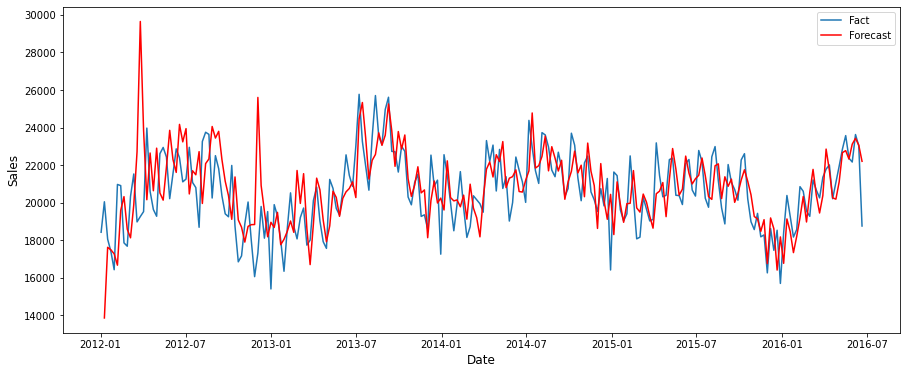

In [102]:
foods_ca['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,6))
plt.plot(foods_ca['date'], foods_ca.sales, label='Fact')
plt.plot(foods_ca['date'][1:], foods_ca['model'][1:], color='r', label='Forecast')
plt.legend()
plt.ylabel('Sales',fontsize=12)
plt.xlabel('Date',fontsize=12)

Student test: p=0.346987
Dickey-Fuller test: p=0.0031204050260735132805989


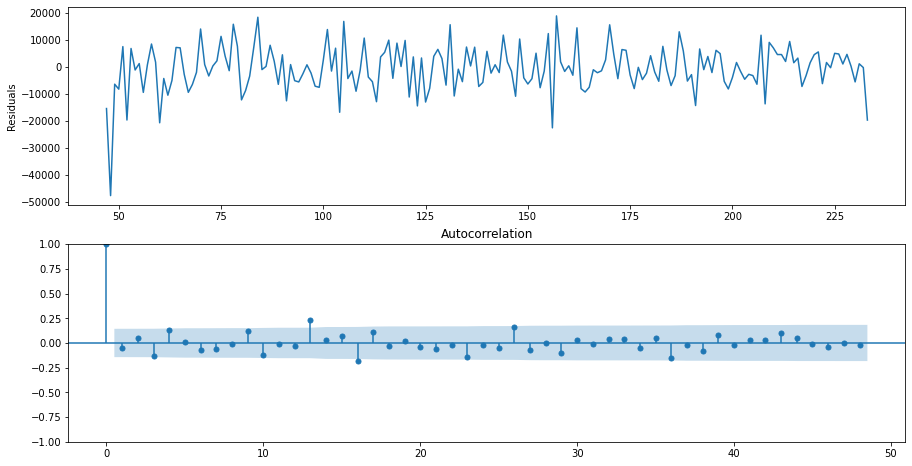

In [587]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[47:].plot()
plt.ylabel('Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[47:].values.squeeze(), lags=48, ax=ax)
print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[47:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[47:])[1])

In [103]:
forecast = best_model.forecast(steps=47)

In [109]:
foods_ca

,date,sales,sales_box,diff_sales,model
0,2012-01-02,18425,87855.095010,NaN,1.000000
1,2012-01-09,20049,97026.618089,1624.0,13860.355374
2,2012-01-16,18056,85790.450890,-1993.0,17622.677065
3,2012-01-23,17397,82121.659069,-659.0,17488.600139
4,2012-01-30,16430,76782.402504,-967.0,17273.420183
...,...,...,...,...,...
229,2016-05-23,22372,110372.139433,-1200.0,22322.473267
230,2016-05-30,22165,109172.645635,-207.0,23116.425807
231,2016-06-06,23629,117697.356476,1464.0,23427.423347
232,2016-06-13,23028,114186.241663,-601.0,23065.472721


In [792]:
foods_ca_forcast= pd.DataFrame(index=pd.date_range(start='2016-06-27',  periods=48,freq='W'), columns= foods_ca[['date','sales']].columns).reset_index()
foods_ca_forcast['forecast'] = invboxcox(best_model.forecast(steps=48), lmbda).reset_index()['predicted_mean']

In [793]:
foods_ca_forcast = foods_ca_forcast.drop(['date'],axis=1).rename(columns = {'index':'date'})

In [794]:
foods_ca_final = pd.concat([foods_ca,foods_ca_forcast ])

Text(0.5, 0, 'Date')

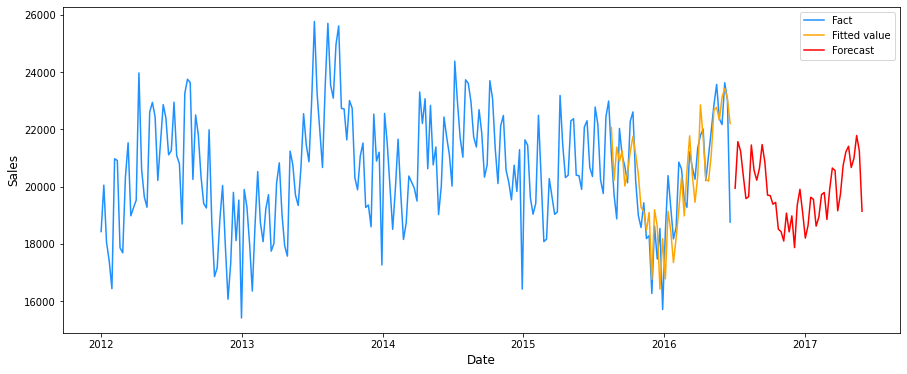

In [795]:

plt.figure(figsize=(15,6))
plt.plot(foods_ca_final['date'], foods_ca_final.sales, label='Fact',color = 'dodgerblue')
plt.plot(foods_ca_final['date'][-47*2+1:], foods_ca_final['model'] [-47*2+1:], color = 'orange', label = 'Fitted value')
plt.plot(foods_ca_final['date'], foods_ca_final.forecast, color='r', label='Forecast')
plt.legend()
plt.ylabel('Sales',fontsize=12)
plt.xlabel('Date',fontsize=12)

# MULTI-STEP LSTM 

In [784]:
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

 
# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    
    # stateful = True - keep state in memory;
    
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss
 
# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]
 
# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
# обратная разность
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted



In [139]:
data = foods_ca[['date', 'sales']].set_index('date')

In [445]:
len(foods_ca)-47

187

In [456]:

n_lag = 47
n_seq = 47
n_test = 5
n_epochs = 20
n_batch = 1
n_neurons =12


In [790]:
 # hyperparameters initialization and training the model

n_lag = 112
n_seq = 47
n_test = 1
n_epochs = 10
n_batch = 1
n_neurons =16


scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)

model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(data, forecasts, scaler, n_test+2)


0


2022-09-28 23:16:03.288721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-28 23:16:03.441261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-28 23:16:03.837253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/66 [============================>.] - ETA: 0s - loss: 0.1249

2022-09-28 23:16:06.011950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-28 23:16:06.060927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 4s 33ms/step - loss: 0.1243 - val_loss: 0.0775
1
66/66 [==============================] - 0s 7ms/step - loss: 0.1066 - val_loss: 0.0655
2
66/66 [==============================] - 0s 6ms/step - loss: 0.0871 - val_loss: 0.0538
3
66/66 [==============================] - 0s 6ms/step - loss: 0.0702 - val_loss: 0.0475
4
66/66 [==============================] - 0s 6ms/step - loss: 0.0593 - val_loss: 0.0452
5
66/66 [==============================] - 0s 6ms/step - loss: 0.0529 - val_loss: 0.0441
6
66/66 [==============================] - 0s 6ms/step - loss: 0.0488 - val_loss: 0.0434
7
66/66 [==============================] - 0s 6ms/step - loss: 0.0460 - val_loss: 0.0430
8
66/66 [==============================] - 0s 5ms/step - loss: 0.0439 - val_loss: 0.0427
9
66/66 [==============================] - 0s 7ms/step - loss: 0.0422 - val_loss: 0.0426
Model: "sequential_207"
_________________________________________________________________
 Layer (type)        

2022-09-28 23:16:10.243390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-28 23:16:10.284722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


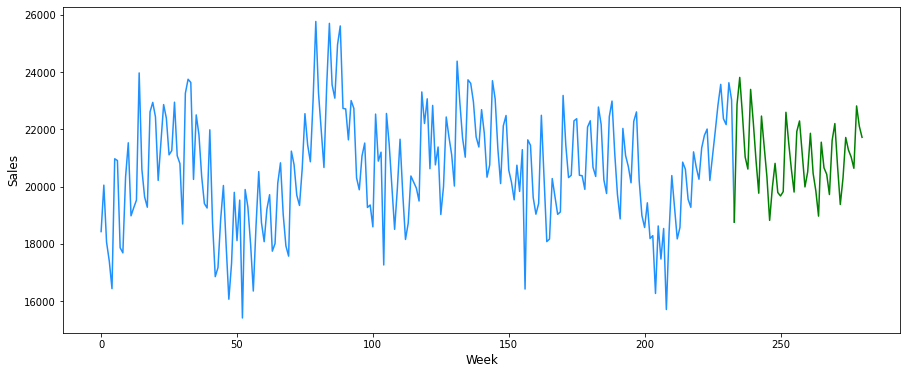

In [791]:
ig=plt.figure(figsize=(15,6))
plt.plot(data.values[:], label='Fact',color = 'dodgerblue')
off_s = len(data) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [data.values[off_s]] + forecasts[-1]
plt.plot(xaxis, yaxis, color='g', label='Forecast LSTM')


plt.ylabel('Sales',fontsize=12)
plt.xlabel('Week',fontsize=12)

plt.show()


# Model comparison

In [798]:
train_set = data[:-48]
scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)
forecasts1 = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts1 = inverse_transform(data, forecasts1, scaler, n_test+2)

In [796]:
y_forecast_arima = np.array(invboxcox(best_model.predict(start=len(data)-48, end=len(data)-1), lmbda))

<Figure size 1080x432 with 0 Axes>

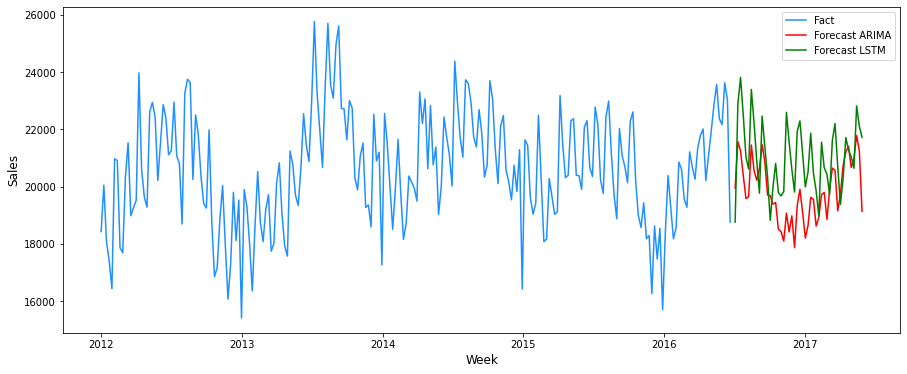

In [808]:
ig=plt.figure(figsize=(15,6))
off_s = len(train_set) - n_test +len(forecasts1)  - 1
off_e = off_s + len(forecasts1[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
y_forecast_lstm = [train_set.values[off_s]] + forecasts1[-1]
plt.figure(figsize=(15,6))
plt.plot(foods_ca_final['date'], foods_ca_final.sales, label='Fact',color = 'dodgerblue')
plt.plot(foods_ca_final['date'], foods_ca_final.forecast, color='r', label='Forecast ARIMA')
plt.plot(foods_ca_final['date'][-48:], yaxis, color='g', label='Forecast LSTM')

plt.legend()
plt.ylabel('Sales',fontsize=12)
plt.xlabel('Week',fontsize=12)



plt.show()

In [805]:
test_accuracy = foods_ca['sales'][-48:]
y_forecast_lstm = np.array(y_forecast_lstm).flatten()
print("ARIMA") 
print("MAPE = ", round(np.mean(np.abs(test_accuracy-y_forecast_arima) /test_accuracy)*100,3))
print("R2 = ",r2_score(test_accuracy,y_forecast_arima))

print("LSTM") 
print("MAPE = ", round(np.mean(np.abs(test_accuracy-y_forecast_lstm) /test_accuracy)*100,3))
print("R2 = ",r2_score(test_accuracy,y_forecast_lstm))

ARIMA
MAPE =  4.591
R2 =  0.6153607161391138
LSTM
MAPE =  8.985
R2 =  -0.32169602375731365


<b>Conclusion</b>

ARIMA model is better than LSTM. 